In [1]:
import csv
import os
import numpy as np
import librosa
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import matplotlib.pyplot as plt
from pywt import wavedec

2023-11-14 15:29:01.850412: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 15:29:01.886388: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 15:29:01.886421: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 15:29:01.886443: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 15:29:01.892505: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-14 15:29:01.893256: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [47]:
csv_uri = '../Preprocessing/test/db1/data_MfccDwtChromaCqtdb1L1.csv'
data = pd.read_csv(csv_uri)
data.head()


,filename,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60,label
0,../data/DWT_NEW/MVP/New_MVP_062.wav,-378.466705,70.777046,-15.043975,-10.483999,-7.787292,-10.019837,-10.438225,-10.765308,-11.529624,...,0.004576,0.007013,0.009191,0.009871,0.007580,0.004856,0.004364,0.004430,0.003150,MVP
1,../data/DWT_NEW/MVP/New_MVP_109.wav,-319.873901,86.987167,-4.425532,-24.986303,-16.058350,-17.620874,-21.183941,-13.546381,-13.906720,...,0.006113,0.007374,0.003911,0.004396,0.006237,0.002841,0.003259,0.001627,0.001817,MVP
2,../data/DWT_NEW/MVP/New_MVP_009.wav,-436.392487,96.536903,15.220769,-3.666383,-7.341067,-16.075756,-19.296213,-12.426279,-12.215953,...,0.001060,0.001288,0.002036,0.002741,0.003057,0.002324,0.001372,0.001019,0.001093,MVP
3,../data/DWT_NEW/MVP/New_MVP_177.wav,-260.900574,82.395615,-14.294676,-40.442722,-28.068470,-14.434702,-11.098033,-15.608220,-18.183039,...,0.040846,0.037475,0.030191,0.031350,0.024266,0.023387,0.018028,0.016594,0.014518,MVP
4,../data/DWT_NEW/MVP/New_MVP_069.wav,-437.852600,95.676224,9.383162,-12.113409,-9.554273,-10.383272,-10.062037,-8.767884,-12.414495,...,0.002557,0.003386,0.003017,0.003608,0.003812,0.002936,0.002787,0.003399,0.002704,MVP


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 114 entries, filename to label
dtypes: float64(112), object(2)
memory usage: 801.7+ KB


In [49]:
# scaler = StandardScaler()
X = data.drop(['label', 'filename'], axis=1)
# X = scaler.fit_transform(X)
# X = np.reshape(X, (-1, X.shape[0], X.shape[1], 1))
y = data.iloc[:, -1]

In [50]:
X.shape

(900, 112)

In [51]:
y.head()

0    MVP
1    MVP
2    MVP
3    MVP
4    MVP
Name: label, dtype: object

In [52]:
X

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
0,-378.466705,70.777046,-15.043975,-10.483999,-7.787292,-10.019837,-10.438225,-10.765308,-11.529624,-6.286917,...,0.003381,0.004576,0.007013,0.009191,0.009871,0.007580,0.004856,0.004364,0.004430,0.003150
1,-319.873901,86.987167,-4.425532,-24.986303,-16.058350,-17.620874,-21.183941,-13.546381,-13.906720,-13.717781,...,0.007207,0.006113,0.007374,0.003911,0.004396,0.006237,0.002841,0.003259,0.001627,0.001817
2,-436.392487,96.536903,15.220769,-3.666383,-7.341067,-16.075756,-19.296213,-12.426279,-12.215953,-12.313032,...,0.001414,0.001060,0.001288,0.002036,0.002741,0.003057,0.002324,0.001372,0.001019,0.001093
3,-260.900574,82.395615,-14.294676,-40.442722,-28.068470,-14.434702,-11.098033,-15.608220,-18.183039,-11.157784,...,0.043850,0.040846,0.037475,0.030191,0.031350,0.024266,0.023387,0.018028,0.016594,0.014518
4,-437.852600,95.676224,9.383162,-12.113409,-9.554273,-10.383272,-10.062037,-8.767884,-12.414495,-6.307548,...,0.002647,0.002557,0.003386,0.003017,0.003608,0.003812,0.002936,0.002787,0.003399,0.002704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-339.158112,40.213173,-36.526974,-53.637939,-18.601725,-12.249957,-10.941161,-9.111422,-10.798549,-5.611834,...,0.035250,0.040663,0.033821,0.044480,0.047381,0.049833,0.045619,0.043067,0.030173,0.025898
896,-501.082001,89.517166,25.677994,-4.297906,-10.959665,-17.939556,-20.772755,-15.514157,-15.844445,-12.956374,...,0.005172,0.003850,0.002997,0.001923,0.001676,0.001316,0.000971,0.000981,0.001023,0.000886
897,-307.757050,51.899139,-23.147026,-28.208418,-22.437355,-13.074753,-12.573600,-9.405491,-10.770848,-8.731351,...,0.032781,0.027149,0.027509,0.045420,0.052697,0.049330,0.044515,0.036902,0.025493,0.022228
898,-334.683624,87.311577,6.389525,-1.465219,-13.921110,-18.471697,-14.806891,-16.474894,-18.158365,-17.774797,...,0.008435,0.009755,0.009753,0.007868,0.007349,0.005529,0.002896,0.002681,0.003235,0.002716


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
y_test.shape

(180,)

In [55]:
X_train.shape

(720, 112)

In [56]:
X_train

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,cqt51,cqt52,cqt53,cqt54,cqt55,cqt56,cqt57,cqt58,cqt59,cqt60
10,-385.906982,74.895340,39.821186,-8.971136,-22.192118,-25.015581,-27.064453,-24.045132,-27.759182,-29.726229,...,0.002294,0.001526,0.002158,0.002329,0.002317,0.001506,0.001128,0.000906,0.000822,0.000770
334,-415.968506,107.517372,44.947140,-2.356348,-16.818644,-22.711168,-24.376642,-19.630342,-19.142199,-15.471057,...,0.003029,0.002132,0.001797,0.001642,0.001062,0.001127,0.000976,0.000559,0.000708,0.000717
244,-427.811066,102.884872,46.127216,6.943640,-10.577306,-21.495943,-30.066357,-20.540812,-12.175126,-10.055816,...,0.004527,0.003815,0.002654,0.001473,0.000573,0.000913,0.000984,0.000708,0.000538,0.000361
678,-358.147736,95.750092,-6.823721,-38.393955,-33.172913,-28.448936,-25.357052,-24.172688,-21.519249,-16.292105,...,0.014000,0.014028,0.014584,0.016448,0.011797,0.013386,0.011898,0.007499,0.006875,0.006322
306,-427.476135,98.611679,36.363655,-0.854163,-14.472300,-24.841476,-19.455835,-19.234936,-19.875013,-20.455000,...,0.002225,0.001244,0.001890,0.001335,0.001256,0.001930,0.001312,0.000906,0.001056,0.000961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-397.429016,77.593384,24.298113,-15.595834,-26.727154,-24.668875,-24.234287,-23.968037,-30.278244,-33.223251,...,0.004297,0.004133,0.005123,0.007229,0.008914,0.008600,0.005154,0.001585,0.001324,0.000832
270,-410.292542,98.300247,44.424370,5.566563,-9.317470,-21.559860,-24.616989,-15.818483,-16.259008,-13.159559,...,0.003473,0.003598,0.002932,0.001842,0.001216,0.000991,0.001201,0.001271,0.000916,0.000585
860,-408.968292,94.780281,24.131092,-8.054283,-17.265577,-19.051916,-18.081953,-19.145655,-21.355644,-19.833616,...,0.006677,0.006362,0.006968,0.005794,0.005023,0.004618,0.003270,0.002189,0.001938,0.001347
435,-383.255219,73.887856,3.322746,-1.166246,-1.575055,-1.824785,-8.054250,-10.752819,-6.060513,-11.980646,...,0.001899,0.001540,0.001212,0.001930,0.003594,0.004990,0.003905,0.001831,0.001534,0.001580


In [57]:
lb = LabelEncoder()
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
print(y_test.shape)
y_test = tf.keras.utils.to_categorical(lb.fit_transform(y_test))
y_train = tf.keras.utils.to_categorical(lb.fit_transform(y_train))
print(X_train.shape)
print(X_test.shape)



(180,)
(720, 112, 1)
(180, 112, 1)


In [58]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [59]:
# make RNN model
def build_model():
    model = models.Sequential(
        [
            # layers.SimpleRNN(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
            
            # layers.Flatten(),
            # layers.Dense(64, activation="relu"),
            # layers.Dense(32, activation="relu"),

            # layers.BatchNormalization(),

            # layers.Dense(5, activation="softmax"),
            layers.SimpleRNN(64,activation='tanh',input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),

            layers.Flatten(),
            layers.Dense(64, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4)),
            layers.Dense(32, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4)),

            layers.BatchNormalization(),

            layers.Dense(5, activation="softmax"),
        ]
    )

    return model

In [60]:
model = build_model()
model.summary()
model_uri = '../modelh5/model_rnn_nontuning.h5'
# model.save(model_uri)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 112, 64)           4224      
                                                                 
 flatten_2 (Flatten)         (None, 7168)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                458816    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                      

In [61]:
optimazer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimazer, loss='categorical_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50


45/45 [==============================] - 2s 19ms/step - loss: 0.7856 - acc: 0.7431 - val_loss: 0.9414 - val_acc: 0.7056
Epoch 2/50
45/45 [==============================] - 1s 14ms/step - loss: 0.4235 - acc: 0.9000 - val_loss: 0.7969 - val_acc: 0.8333
Epoch 3/50
45/45 [==============================] - 1s 14ms/step - loss: 0.3228 - acc: 0.9111 - val_loss: 0.5752 - val_acc: 0.8944
Epoch 4/50
45/45 [==============================] - 1s 14ms/step - loss: 0.2694 - acc: 0.9417 - val_loss: 0.4403 - val_acc: 0.9167
Epoch 5/50
45/45 [==============================] - 1s 17ms/step - loss: 0.2398 - acc: 0.9458 - val_loss: 0.4031 - val_acc: 0.9000
Epoch 6/50
45/45 [==============================] - 1s 14ms/step - loss: 0.2338 - acc: 0.9486 - val_loss: 0.3041 - val_acc: 0.9389
Epoch 7/50
45/45 [==============================] - 1s 14ms/step - loss: 0.1859 - acc: 0.9625 - val_loss: 0.2320 - val_acc: 0.9667
Epoch 8/50
45/45 [==============================] - 1s 20ms/step - loss: 0.1551 - acc: 0.9778 

6/6 [==============================] - 0s 6ms/step - loss: 0.0679 - acc: 0.9889
Accuracy on test set is: 0.9888888597488403


Text(0, 0.5, 'Accuracy')

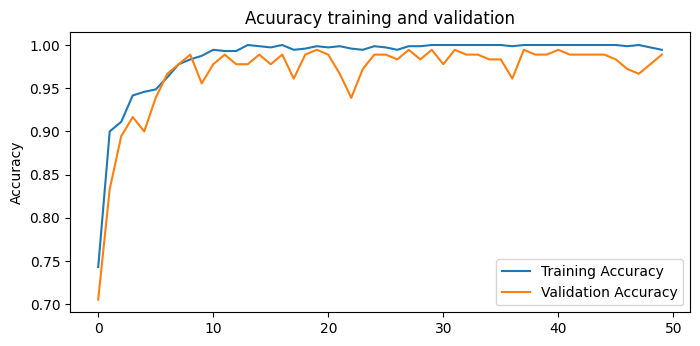

In [62]:
# evaluate model on test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on test set is: {}".format(test_accuracy))


# plot accuracy/error for training and validation
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Acuracy training and validation')
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')

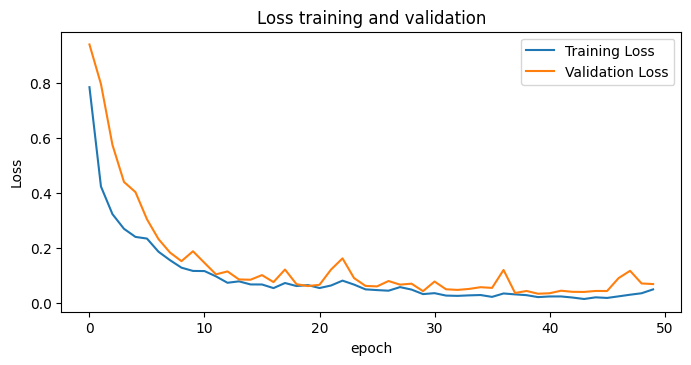

In [63]:
# loss
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.title('Loss training and validation')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()


In [64]:
# model.save(model_uri)

In [65]:
# confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_p = np.argmax(y_pred, axis=1)
y_t = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_t, y_p)
cm

6/6 [==============================] - 0s 4ms/step


array([[35,  0,  0,  0,  0],
       [ 0, 29,  2,  0,  0],
       [ 0,  0, 38,  0,  0],
       [ 0,  0,  0, 35,  0],
       [ 0,  0,  0,  0, 41]])

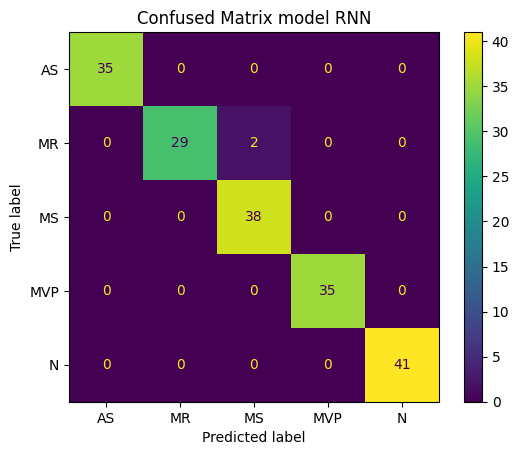

In [66]:
# confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
disp.plot()
plt.title('Confused Matrix model RNN Tuning')
plt.show()

In [67]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [68]:
print('sensitivity: ', TPR)
print('specificity: ', TNR)
print('precision: ', PPV)
print('negative predictive value: ', NPV)
print('false positive rate: ', FPR)
print('false negative rate: ', FNR)
print('false discovery rate: ', FDR)
print('accuracy: ', ACC)
print('f1-score', 2*(PPV*TPR)/(PPV+TPR) )

sensitivity:  [1.         0.93548387 1.         1.         1.        ]
specificity:  [1.         1.         0.98591549 1.         1.        ]
precision:  [1.   1.   0.95 1.   1.  ]
negative predictive value:  [1.         0.98675497 1.         1.         1.        ]
false positive rate:  [0.         0.         0.01408451 0.         0.        ]
false negative rate:  [0.         0.06451613 0.         0.         0.        ]
false discovery rate:  [0.   0.   0.05 0.   0.  ]
accuracy:  [1.         0.98888889 0.98888889 1.         1.        ]
f1-score [1.         0.96666667 0.97435897 1.         1.        ]


In [69]:
# classification_report
from sklearn.metrics import classification_report

print(classification_report(y_t, y_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      0.94      0.97        31
           2       0.95      1.00      0.97        38
           3       1.00      1.00      1.00        35
           4       1.00      1.00      1.00        41

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



### Testing

In [8]:
model_uri = '../modelh5/model_rnn_nontuning.h5'
new_model = tf.keras.models.load_model(model_uri)
new_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 112, 64)           4224      
                                                                 
 flatten_1 (Flatten)         (None, 7168)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                458816    
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                      

In [9]:
import wave
import json
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
for i in range(1, 13):
  header += f' chroma{i}'
for i in range(1, 61):
  header += f' cqt{i}'
header += ' label'
header = header.split()


def extract_mfcc(audiofile):
    file = open('test.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    y, sr = librosa.load(audiofile, mono=True, duration=3, sr=8000)
    coeffs = wavedec(y, 'db1', level=10)
    cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
    mfcc = librosa.feature.mfcc(y=cD1, sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
    rms = librosa.feature.chroma_stft(y=cD1, sr=8000)
    cqt = np.abs(librosa.cqt(y=cD1, sr=sr, n_bins=60)) 
    combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
    to_append = f'Signal'
    for e in combined_features:
        to_append += f' {np.mean(e.T, axis=0)}'
    file = open('test.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

def predict(audio):
    model = tf.keras.models.load_model(model_uri)
    extract_mfcc(audio)
    data = pd.read_csv('test.csv')
    df = data.drop(['label', 'filename'], axis=1)
    pred = model.predict(df)
    class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
    cek = np.argmax(pred[0])
    print(pred[0])
    print(cek)
    print(f'Predicted class: {class_labels[cek]}')

In [14]:
predict('../physionet/f0005.wav')

1/1 [==============================] - 0s 148ms/step
[0.15597291 0.18695167 0.17766596 0.01664289 0.46276656]
4
Predicted class: N
